In [4]:
# MY SIMULATION 
import itertools
%matplotlib inline
import os
import random 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import vertex_model as model
# from vertex_model.run_select_nosaveinfo import run_simulation_INM, definecolors, run_simulation_no_INM
import itertools
import numpy as np
import matplotlib.pyplot as plt
import vertex_model as model
import vertex_model.initialisation as init
import vertex_model.characterization as crt
import vertex_model.save_data as save
from vertex_model.forces import TargetArea, Tension, Perimeter, Pressure
import os
import seaborn as sns
import warnings
import matplotlib.colors as colors
warnings.filterwarnings('ignore') #Don't show warnings
#from Gobal_Constant import dt, viscosity, t_G1, t_G2, t_S, A_c, J, pos_d, T1_eps, P, microns, time_hours, expansion_constant #file with necessary constants
from vertex_model.run_select import save_data
sns.set_style("whitegrid")
from scipy.spatial import Delaunay
import math
from scipy.spatial import ConvexHull

# Cell centres computation of a given mesh

In [5]:
def draw_edges(mesh, ax):
    w1 = mesh.vertices
    r = mesh.edges.rotate
    w2 =  mesh.vertices.take(r, 1) 
    w = w1-w2 # winding
    to_draw = mesh.edges.ids[(mesh.edges.ids < mesh.edges.reverse) | (np.abs(w[0])+np.abs(w[1]) > 0.1)]
    start, end = mesh.vertices.take(to_draw, 1), mesh.vertices.take(mesh.edges.next[to_draw], 1)
    n = np.empty(len(start[0]))
    n.fill(np.nan)
    x = np.dstack([start[0], end[0], n]).ravel()
    y = np.dstack([start[1], end[1], n]).ravel()
    return x, y

In [6]:
n_cell_up = 7
n_cell_across = 8

In [7]:
hex_centres = init.hexagonal_centres(n_cell_up, n_cell_across, 0.2, rand= np.random.RandomState())
mesh = init.toroidal_ic_mesh(hex_centres)
x, y = draw_edges(mesh, plt) 

In [8]:
def cell_vertices(mesh, id):   
    """
    Computes the coordinates of the vertices of a cell
    mesh: mesh object
    id: id of the cell whose vertices have to be computed 
    """ 
    cell_i = []
    for i in range(len(mesh.face_id_by_edge)):
        if mesh.face_id_by_edge[i] == id:
            cell_i.append(i)
    return cell_i
def centroid(vertexes_x, vertexes_y):   
     """
     Computes the centroid of a polygon
     vertexes_x: x coordinates of the vertices of a polygon 
     vertexes_y: y coordinates of the vertices of a polygon 
     """
     _len = len(vertexes_x)
     _x = sum(vertexes_x) / _len
     _y = sum(vertexes_y) / _len
     return(_x, _y)
def centroid_polygon(cell_area, vx, vy):
    n = len(vx)
    v_x = vx.tolist(); v_y = vy.tolist()
    v_x.append(v_x[0]); v_y.append(v_y[0])
    x = []; y = []
    for i in range(n):
        x = x + ((v_x[i]+v_x[i+1])*(v_x[i]*v_y[i+1]-v_x[i+1]*v_y[i]))
        y = y +  ((v_y[i]+v_y[i+1])*(v_x[i]*v_y[i+1]-v_x[i+1]*v_y[i]))
    x = x /(6*cell_area);     y = y /(6*cell_area); 
    return (x, y)
def mesh_centres(mesh):
    '''
    Compute the centres of the cells of a given mesh 
    '''
    centres_x =[]
    centres_y = [] 
    centres =np.zeros((mesh.n_face, 2))
    for i in range(mesh.n_face):       
       cell_i = cell_vertices(mesh, i) #vertices of the ith cell 
       area_i = mesh.area[i]
       if len(mesh.vertices[0][cell_i]) != 0:
        cell_center_i = centroid(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i])
        centres_x.append(cell_center_i[0])
        centres_y.append(cell_center_i[1])
        #centres.append(np.array([cell_center_i[0],cell_center_i[1] ]))
        centres[i, 0] = cell_center_i[0]
        centres[i, 1] = cell_center_i[1]
    return centres_x, centres_y, centres

def circumcenter(vertices):
    """ 
    Computes the circumcentre of a polygon
    vertices: coordinates of the vertices of the polygon whose circumcentre has to be computed 
    """
    hull = ConvexHull(vertices)
    edges = hull.points[hull.simplices]

    circumcenters = []
    for edge in edges:
        x1, y1 = edge[0]
        x2, y2 = edge[1]
        x3, y3 = edge[2]

        A = np.array([[x2 - x1, y2 - y1], [x3 - x1, y3 - y1]])
        b = 0.5 * np.array([[(x2 - x1) ** 2 + (y2 - y1) ** 2], [(x3 - x1) ** 2 + (y3 - y1) ** 2]])
        try:
            circumcenter = np.linalg.solve(A, b)
            circumcenter = [circumcenter[0][0] + x1, circumcenter[1][0] + y1]
            circumcenters.append(circumcenter)
        except np.linalg.LinAlgError:
            pass

    circumcenter = np.mean(circumcenters, axis=0)
    return circumcenter



## 1. Original cells and computed vertices and centres

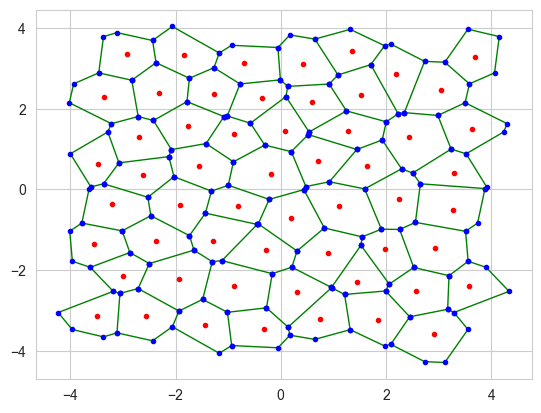

In [9]:
a = x[0:-1]
b = y[0:-1]
plt.plot(a,b, 'k-', linewidth=1.0, color='green')
b = mesh.boundary_faces
x_centers = []
y_centers = []
for i in range(mesh.n_face):
    cell_i = cell_vertices(mesh, i)
    plt.plot(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i], '.', color ='blue')
    cell_center_i = centroid(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i])
    plt.plot(cell_center_i[0],cell_center_i[1], '.', color ='red')
    x_centers.append(cell_center_i[0])
    y_centers.append(cell_center_i[1])


## 3. Original vertices and cells and new centres. 

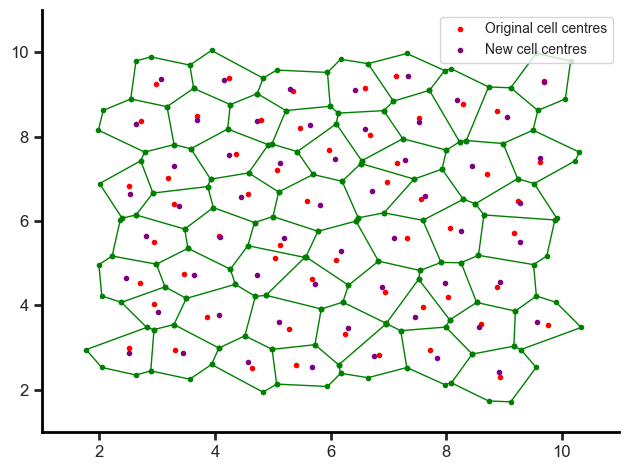

In [30]:
a = x[0:-1]
b = y[0:-1]
plt.plot(a,b, 'k-', linewidth=1.0, color='green')
plt.plot(hex_centres[0][:,0], hex_centres[0][:, 1], '.',color='red', label='Original cell centres', linewidth =1)
plt.plot(mesh.vertices[0], mesh.vertices[1], '.', color = 'green')
b = mesh.boundary_faces
x_centers = []
y_centers = []
for i in range(mesh.n_face):
    cell_i = cell_vertices(mesh, i)
    #plt.plot(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i], '.', color ='black')
    cell_center_i = centroid(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i])
    if i ==0: 
        plt.plot(cell_center_i[0],cell_center_i[1], '.', color ='purple', label='New cell centres', linewidth =2)
    else:
            plt.plot(cell_center_i[0],cell_center_i[1], '.', color ='purple', linewidth =2)

    x_centers.append(cell_center_i[0])
    y_centers.append(cell_center_i[1])
ax = plt.gca()

ax.spines['left'].set_linewidth(2)   # Left Y-axis
ax.spines['bottom'].set_linewidth(2) # Bottom X-axis
ax.spines['top'].set_linewidth(0) # Bottom X-axis
ax.spines['right'].set_linewidth(0) # Bottom X-axis

ax.spines['left'].set_color('black')   # Left Y-axis
ax.spines['bottom'].set_color('black') # Bottom X-axis

plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.tick_params(axis='both', which='major', labelsize=12)
plt.rcParams['ytick.labelsize']= 8
plt.rcParams['xtick.labelsize']= 8
plt.rcParams['legend.fontsize'] = 10
plt.tight_layout()
# plt.xlim(-600,600); plt.ylim(-600, 600)
plt.grid(False)
plt.legend(loc='upper right')
plt.xticks([-6, -4, -2, 0, 2, 4], [0, 2,  4,  6,  8, 10])
plt.yticks([-6, -4, -2, 0, 2, 4], [0, 2,  4,  6,  8, 10])
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()



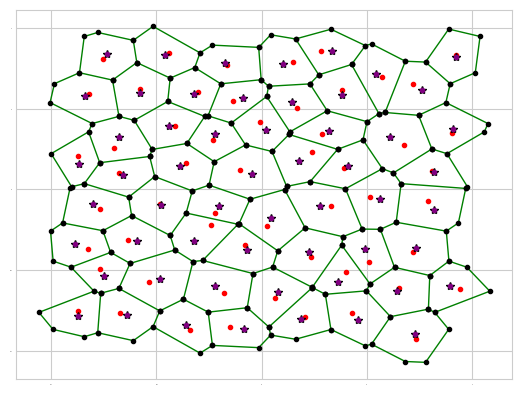

In [17]:
a = x[0:-1]
b = y[0:-1]
plt.plot(a,b, 'k-', linewidth=1.0, color='green')
plt.plot(hex_centres[0][:,0], hex_centres[0][:, 1], '.',color='red')
#plt.plot(mesh.vertices[0], mesh.vertices[1], '.', color = 'blue')
b = mesh.boundary_faces
x_centers = []
y_centers = []
my_centres = []
for i in range(mesh.n_face):
    cell_i = cell_vertices(mesh, i)
    plt.plot(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i], '.', color ='black')
    xc=np.mean(mesh.vertices[0][cell_i])
    yc = np.mean(mesh.vertices[1][cell_i])
    plt.plot(xc, yc, '*', color = 'black')
    cell_center_i = centroid(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i])
    plt.plot(cell_center_i[0],cell_center_i[1], '.', color ='purple')
    x_centers.append(cell_center_i[0])
    y_centers.append(cell_center_i[1])
    my_centres.append([cell_center_i[0],cell_center_i[1]])

## 4. Circumcentres


In [28]:
# a = x[0:-1]
# b = y[0:-1]
# plt.plot(a,b, 'k-', linewidth=1.0, color='green')
# plt.plot(hex_centres[0][:,0], hex_centres[0][:, 1], '.',color='red')
# b = mesh.boundary_faces
# x_centers = []
# y_centers = []

# for i in range(mesh.n_face):
#     cell_i = cell_vertices(mesh, i)
#     cv = np.zeros((len(cell_i), 2))
#     for j in range(len(cell_i)):
#         v = cell_i[j]
#         cv[j][0] = mesh.vertices[0][v]
#         cv[j][1] = mesh.vertices[1][v]
#     cc = circumcenter(cv)
#     plt.plot(cc[0], cc[1], color='orange')
#     plt.plot(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i], '.', color ='blue')
#     cell_center_i = centroid(mesh.vertices[0][cell_i], mesh.vertices[1][cell_i])
#     plt.plot(cell_center_i[0],cell_center_i[1], '.', color ='purple')
#     x_centers.append(cell_center_i[0])
#     y_centers.append(cell_center_i[1])
    

## 5. Mesh generated with the centroids


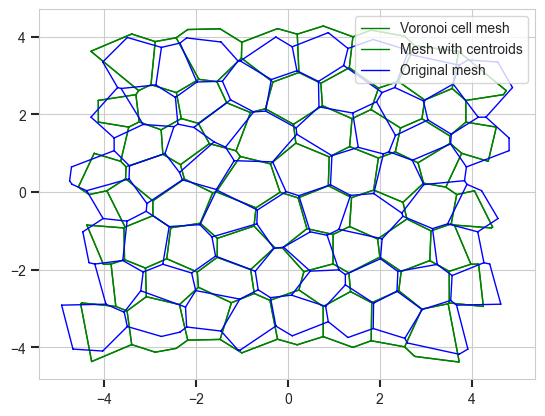

In [29]:
inicial = (np.array(my_centres), 8, 8)
my_mesh = init.toroidal_ic_mesh(inicial)
model.plotting._draw_edges(my_mesh, plt) 
x2, y2 = draw_edges(my_mesh, plt)
a2 = x2[0:-1]
b2 = y2[0:-1]
plt.plot(a2,b2, 'k-', linewidth=1.0, color='green', label = 'Mesh with centroids')
a = x[0:-1]
b = y[0:-1]
plt.plot(a,b, 'k-', linewidth=1.0, color='blue', label='Original mesh')
plt.legend()